In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa 

### Line plots
- Lets create a simple Line plot based on a random Pandas Series.


<Axes: >

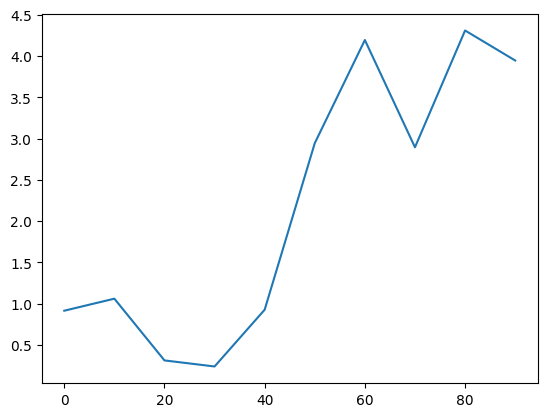

In [2]:
s = pd.Series(np.random.randn(10).cumsum(), index=np.arange(0, 100, 10))
s.plot()

- The Series object’s index is passed to matplotlib for plotting on the x-axis, though you can disable this by passing use_index=False. 
- The x-axis ticks and limits can be adjusted with the xticks and xlim options, and y-axis respectively with yticks and ylim.


<Axes: >

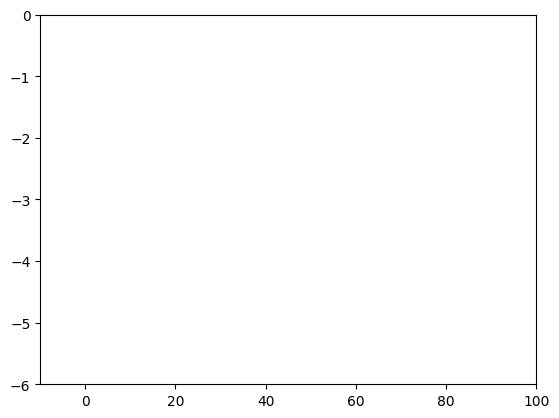

In [3]:
s.plot(ylim=[-6,0], xlim=[-10,100])

- To use subplots, you have to declare the axes first. 
- Most of pandas’s plotting methods accept an optional ax parameter, which can be a matplotlib subplot object. This gives you more flexible placement of subplots in a grid layout. 


<Axes: >

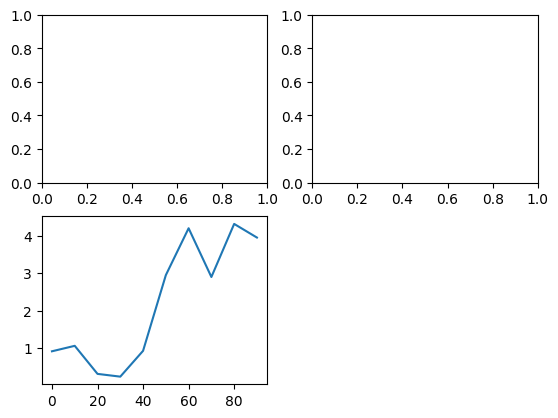

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
s.plot()

- What would happen if you use a DataFrame instead of a Series object?
- DataFrame’s plot method plots each of its columns as a different line on the same subplot, creating a legend automatically. 
- You would have to plot all lines individually if you were using only the matplotlib API.

<Axes: >

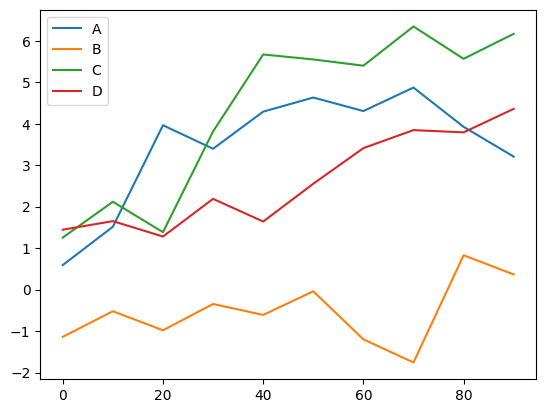

In [5]:
df = pd.DataFrame(np.random.randn(10, 4).cumsum(0),
                  columns=['A', 'B', 'C', 'D'],
                  index=np.arange(0, 100, 10))

df.plot()

- To create separate subplots for each column you have to use the attribute subplots = True.
- By default, the plots will be displayed sharing the x axis, with similar ranges.

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

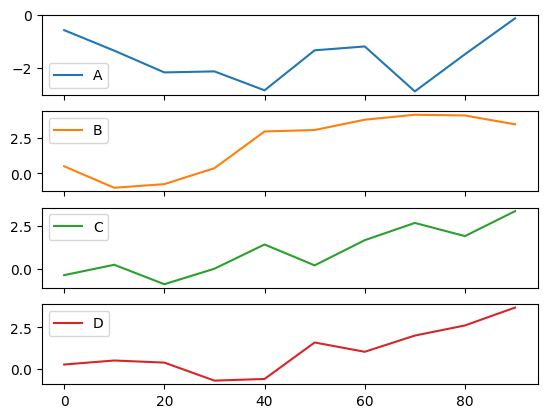

In [6]:
df = pd.DataFrame(np.random.randn(10, 4).cumsum(0),
                  columns=['A', 'B', 'C', 'D'],
                  index=np.arange(0, 100, 10))
df.plot(subplots=True)

- If you use the attribute sharey = True, the plots will have the same y-axis range

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

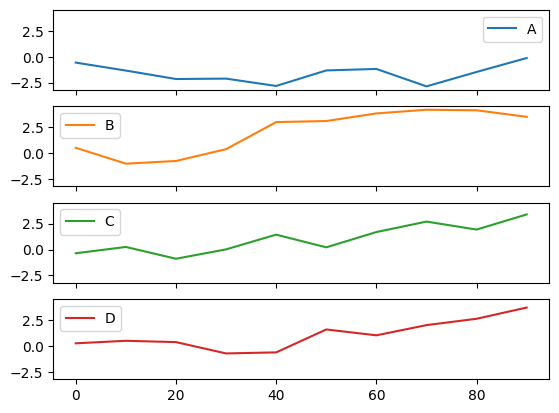

In [7]:
df.plot(subplots=True, sharey=True)

### Scatter plots

- Point plots or scatter plots can be a useful way of examining the relationship between two one-dimensional data series. 
- Humans are not very good at reading very large tables of data. For example, take a look at this table showing the genome size and number of genes for reptiles: 


In [8]:
euk = pd.read_table("Datasets/eukaryotes.tsv")

euk["Number of genes"] = euk["Number of genes"].replace("-", "0").astype(int)
euk["Number of proteins"] = euk["Number of proteins"].replace("-", "0").astype(int)

reptiles = euk[(euk["Class"] == "Reptiles")& (euk["Number of genes"] > 1000).fillna(False) ]

reptiles[["Species", "Size (Mb)", "Number of genes"]]

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/eukaryotes.tsv'

- Even for this small dataset, it’s very time consuming to compare the numbers. 
- But if we view the exact same data as a scatter plot it only takes a glance to see the positive correlation.

In [ ]:
sns.relplot(data=reptiles , x="Size (Mb)", y="Number of genes")
plt.title("Genome size and number of genes for reptiles", pad=20)

- We can then use seaborn’s regplot method, which makes a scatter plot and fits a linear regression line.
- The relationship between the variables is even more clear with this kind of plot.

In [ ]:
sns.regplot(data=reptiles, x='Size (Mb)', y='Number of genes')
plt.title("Genome size and number of genes for reptiles", pad=20)

### Histograms
- A histogram is a kind of bar plot that gives a discretized display of value frequency. 
- The data points are split into discrete, evenly spaced bins, and the number of data points in each bin is plotted. 
- We can make a histogram of GC content (%) of Reptiles genomes using the plot.hist method on the Series


In [ ]:
euk["GC%"] = euk["GC%"].replace("-", np.nan).astype(float)

In [ ]:
euk["GC%"].plot(kind="hist", bins=50)

- To generate the same type of visualisation using seaborn, you have to use the distplot function.
- This function takes a list of values, which can be in the form of a pandas series.


In [ ]:
sns.distplot(euk["GC%"].dropna())

- The previous plot looks pretty good, but we can tweak the attributes to make it better.

In [ ]:
# set the shape of the plot
plt.figure(figsize=(8, 4))
sns.distplot(euk["GC%"].dropna(), color = "red",bins =100 ,kde=False)
# set the x limit between 0 and 100 for a percentage plt.xlim((0, 100))
plt.xlim((0, 80))
# set a title for the chart
plt.title("Distribution of GC percentage across eukaryote genomes")

- Notice that to generate this plot we need to use both seaborn and matplotlib. Some aspects of the chart, like the color and the number of bins, are arguments to distplot, but others, like the title and x axis limits, have to be set by calling functions in plt.
- Glancing at the distribution of GC percentage in the chart above, it looks like there might be a few different subpopulations. To see if these correspond to kingdoms, let’s plot the genomes belonging to each kingdom separately.
- We’ll use pandas to get a list of the different unique kingdom names, and to select just those genomes from the dataframe
- Then we’ll call distplot once for each group of genomes, attaching a label so that seaborn can draw a legend for us. If we draw a histogram for each group then the chart will be very cluttered, so we’ll avoid drawing the bars with hist=False and just plot the KDE.

In [ ]:
plt.figure(figsize=(8, 4))
# for each unique kingdom ...
for kingdom in euk["Kingdom"].unique():
# ... select just the rows for that kingdom ... 
    one_kingdom = euk[euk["Kingdom"] == kingdom]
# ... and plot the GC values 
    sns.distplot(one_kingdom["GC%"].dropna(), hist=False, label=kingdom)
plt.title("Distribution of GC percentage for genomes\nbelonging to different kingdoms")
plt.legend(loc=9, bbox_to_anchor=(1.15, 1.01), prop={'size': 12}, title = 'Kingdom', 
          fontsize = 14, frameon=None)

### Let's remake a complicated visualisation
- Do you guys remember one of our last week's visualisations?


In [ ]:
euk_reduced = euk[euk["Size (Mb)"] < 5000]
euk_reduced = euk_reduced[euk_reduced["Number of genes"]>0]

fig, ax = plt.subplots(figsize = [8,6])
grouped = euk_reduced[["Kingdom", "Size (Mb)", "Number of genes"]].groupby("Kingdom")

for names, data in grouped:
    ax.scatter(data["Size (Mb)"], data["Number of genes"], cmap = 'Pastel1', marker = "o", s=70
               , label=names,linewidths = 1, edgecolors = "black")
ax.legend(loc=9, bbox_to_anchor=(1.15, 1.01), prop={'size': 12}, title = 'Kingdom', 
          fontsize = 14, frameon=None)

ax.set_xlabel("Genome (Mb)")
ax.set_ylabel("Number of genes")
ax.set_title("Plot of Genome size vs number of genes color coded")

- Let's make it easier with seaborn

In [ ]:
sns.relplot( data=euk_reduced , x="Size (Mb)"
            , y="Number of genes", hue="Kingdom")
plt.title("Genome size vs number of genes\n for animal genomes")

- We can actually use other attributes to increase the level of complexity, such as style.
- Style will change the displayed symbol based on a group variable, in our case, Kingdom.
- In other words, we are color coding based on the Class, but changing the symbol based on the Kingdom.

In [ ]:
sns.relplot( data=euk_reduced , x="Size (Mb)", y="Number of genes"
            , hue="Class", style="Kingdom")
plt.title("Genome size vs number of genes\n for animal genomes")

- Another property that we can map is size. Let’s plot number of genes versus number of proteins and have the size of each point determined by the size of the genome.
- We will reuse the filtered animals dataframe that we created earlier

In [ ]:
sns.relplot( data=reptiles ,x="Number of genes",
            y="Number of proteins", size="Size (Mb)", sizes=(2, 150),)
plt.title("Number of genes vs number of proteins\n for animal genomes")

- Let's include the Genus information to have higher level insights

In [ ]:
reptiles["Genus"] = [re.sub(r'\s.{1,}', '', species) 
                     for species in reptiles['Species']]
sns.relplot( data=reptiles ,x="Number of genes"
            ,y="Number of proteins", size="Size (Mb)"
            , sizes=(2, 150),hue="Genus")
plt.title("Number of genes vs number of proteins\n for mammal genomes")

In [ ]:
reptiles[reptiles["Genus"]==""]

### Categorical plots

- Up until now we only saw charts that are intended to show how two continuous variables are jointly distributed.
- These charts fundamentally help us to answer questions about the relationships between two variables, which can be a simple case of correlation or a more complicated pattern. 
- Now we will discuss another type, or family, of chart types, the categorical charts.
- They are those that primarily allow us to look at how distributions of values differ between groups. 


### Barplots
- The plot.bar() and plot.barh() make vertical and horizontal bar plots, respectively. 
- In this case, the Series or DataFrame index will be used as the x (bar) or y (barh) ticks.


In [ ]:
fig, axes = plt.subplots(2, 1)
data = pd.Series(np.random.rand(16), index=list('abcdefghijklmnop'))
data.plot(ax=axes[0], kind="bar", color='k', alpha=0.7)
data.plot(ax=axes[1], kind="barh", color='k', alpha=0.7)

### Grouped barplots
- With a DataFrame, bar plots group the values in each row together in a group in bars, side by side, for each value.

In [ ]:
df = pd.DataFrame(np.random.rand(6, 4),
                  index=['one', 'two', 'three', 'four', 'five', 
                         'six'],
                  columns=pd.Index(['Klebsiella', 'Escherichia', 
                                    'Pneumonas', 'Treponema'], name='Genus'))
df.plot(kind="bar")

### Stacked barplots

- You can create a stacked barplot with the very same code using the attribute stacked = True!!!


In [ ]:
df.plot(kind="bar",stacked = True)

### Catplot

In [ ]:
animals = euk_reduced[euk_reduced["Kingdom"]=="Animals"]
sns.catplot(data=animals , y="Class", x="Number of genes", aspect=2,)
plt.title("Number of genes for animal genomes in different classes")

- Like relplot, catplot accepts the use of the hue attribute to further categorize the data.

In [ ]:
animals_and_plants = pd.concat([animals, euk_reduced[euk_reduced["Kingdom"]=="Plants"]])
g = sns.catplot( data=animals_and_plants , x="Publication year", y="Size (Mb)",
aspect=2,
hue="Assembly status",
row="Kingdom", )
g.fig.suptitle(
"Genome size for plants and animals in different assembly status", y=1.05
)

- The average size of sequenced genomes has increased for plants, but not so much for animals.
- The colors show us that the vast majority of animal genomes sequenced since about 2010 have been assembled to scaffold status, whereas there’s much more variation in the status of plant genomes. 
- The animal genomes seem to fall into roughly two groups with either relatively high or low size, with a gap around 1000 to 2000 Mb. 
- Maybe these groups corresponds to taxonomic groups? Let’s check it out.


In [ ]:
g = sns.catplot( data=animals_and_plants , x="Publication year", y="Size (Mb)",
aspect=2,
hue="Class",
row="Kingdom",
palette="Set2", )
g.fig.suptitle("Genome size for plants and animals colored by class", y=1.05)

<div style="padding-top:10px;">
    <h3>Back to CODA</h3>
</div>

In [ ]:
class DataFrameValidationError(Exception):
    def __init__(self):
        super().__init__(f"The input used doesn't have the correct format. Please check your input and try again.")

def composition(CountsDataFrame):
    """
    Transform the counts table into compositions:

    Args:
    _____
    DataFrame (int): Dataframe containing count values
    options:
    freq - Transform the table into frequencies
    perc - Transform the table into percentages

    Return:
    _______
        Dataframe containing compositional data
    """

    CountsDataFrame = CountsDataFrame.replace(0,1)
    if validate_counts(CountsDataFrame) ==False:
        raise DataFrameValidationError
    else:
        return(CountsDataFrame.div(CountsDataFrame.sum(axis=0))*100)

def validate_counts(DataFrame):
    """
    Validate the input to check if the sum of components is
    
    different from a pre-defined upper-limit (1 or 100).
    Args:
    _____
    DataFrame (int): Dataframe containing count values

    Return:
    _______
        Boolean variable
    """
    return(all(round(DataFrame.sum(),1)!=1.0) and all(DataFrame.sum()!=100.0))

def validate_composition(DataFrame):
    """
    Validate the input to check if the sum of components is 1 or 100.
    
    Args:
    _____
    DataFrame (float): Dataframe containing compositional data

    Return:
    _______
        Boolean variable
    """
    return(all(round(DataFrame.sum(),1)==1.0) or all(round(DataFrame.sum(),1)==100.0))


def clr(DataFrame):
    """
    Transform the compositional table into Centered log-ratios
    CLR = log(Composition/geometric mean)

    Args:
    _____
    DataFrame (float): Dataframe containing compositional data.

    Return:
    _______
        CLR transformed dataframe
    """
    if validate_composition(DataFrame) ==False:
        raise DataFrameValidationError
    else:
        DataFrame = DataFrame.T
        gmeans = np.log(DataFrame).mean()
        clr = np.log(DataFrame)-gmeans
        return(clr)

def alr(DataFrame, ref):
    """
    Transform the compositional table into Aitchison log-ratios    
    ALR = log(Composition/reference)

    Args:
    _____
    DataFrame (float): Dataframe containing compositional data.
    ref (str): Composition being used as reference for the log-ratio.
    Return:
    _______
        ALR transformed dataframe
    """
    if validate_composition(DataFrame) ==False:
        raise DataFrameValidationError
    else:
        reference = DataFrame.T[ref]
        alr = np.log(DataFrame.T.div(reference, axis=0))
        return(alr.drop(ref,axis=1).T)


def Aitchison_Distance(Dataframe):
    """
    Calculate the euclidian distance between samples based on CLR transformed data.

    Args:
    _____
    DataFrame (float): Dataframe containing clr-transformed data.
    
    Return:
    _______
    Dataframe containing the euclidian distance between samples.
    """
    aitchison_distance = squareform(pdist(Dataframe))
    aitchison_distance = pd.DataFrame(aitchison_distance, index=Dataframe.index, columns=Dataframe.index)
    return aitchison_distance

<div style="padding-top:10px; padding-bottom:10px;">
    <h3>Aitchison distance:</h3>
    <p>Another advantage of CLR transformed data is that we can measure the Euclidian distance between them….</p>
    <p>And that can be used as a beta diversity metric! This is known as the Aitchison distance.</p>
    <p>You can easily calculate this distance by using a combination of the functions squareform and pdist.</p>    
</div>

In [ ]:
fecalAsvs = pd.read_table("Datasets/fecal_asvs.tsv", index_col=0)
metadata = pd.read_table("Datasets/Metadata.tsv", index_col=0)
alpha = pd.read_table("Datasets/alpha-diversity.tsv")

In [10]:
fullASVs= pd.read_table("Datasets/Bacteria_full_table_final.txt", index_col=0)

In [ ]:
#calculating the CLR
clrFeces = clr(composition(fecalAsvs.T))

pcoa_results = pcoa(Aitchison_Distance(clrFeces))

new_df = pd.DataFrame(pcoa_results.samples[["PC1", "PC2"]])
new_df["index"] = clrFeces.index
new_df.set_index("index", inplace=True)
new_df= new_df.merge(metadata, right_index=True, left_index=True)


In [ ]:
sns.relplot(data = new_df, x = "PC1", y= "PC2", hue = "Diet" , height=3, s=55, aspect = 8/3)
plt.title("Aitchison distance of bovine fecal Microbiome")
plt.xlabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[0]*100,2)}%")
plt.ylabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[1]*100,2)}%")

In [ ]:
dfPlusAlpha = alpha.merge(new_df, right_index=True, left_index=True)

In [ ]:
sns.relplot(data = dfPlusAlpha, x = "PC1", y= "PC2", hue = "shannon", style = "Diet", s= 55, height=3, aspect = 8/3)
plt.title("Aitchison distance of bovine fecal Microbiome")
plt.xlabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[0]*100,2)}%")
plt.ylabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[1]*100,2)}%")

In [ ]:
metadata2 = pd.read_table("Datasets/metadata2.tsv", index_col=0)

In [ ]:
dfPlusCar = new_df.merge(metadata2[["CAR"]], right_index=True, left_index=True)
sns.relplot(data = dfPlusCar, x = "PC1", y= "PC2", hue = "CAR", style = "Diet", s= 55, height=3, aspect = 8/3)
plt.title("Aitchison distance of bovine fecal Microbiome")
plt.xlabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[0]*100,2)}%")
plt.ylabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[1]*100,2)}%")

In [ ]:
#calculating the CLR
clrAll = clr(composition(fullASVs.T))
distance = Aitchison_Distance(clr(composition(fullASVs.fillna(0))))


In [ ]:
pcoa_results = pcoa(Aitchison_Distance(clr(composition(fullASVs.fillna(0)))))

In [ ]:
pcoa_results

In [ ]:
new_df = pd.DataFrame(pcoa_results.samples[["PC1", "PC2"]])
#new_df["index"] = clrFeces.index
#new_df.set_index("index", inplace=True)
#new_df= new_df.merge(metadata, right_index=True, left_index=True)
new_df["index"] = distance.index

new_df.set_index("index", inplace=True)
new_df["Biome"] = ["Feces" if "F" in x else "Rumen" for x in new_df.index]
new_df["Diet"] = ["Conventional" if "Con" in x else "Byproduct" for x in new_df.index]

In [ ]:
sns.relplot(data = new_df, x = "PC1", y= "PC2", hue = "Biome", style="Diet" , height=3, s=55, aspect = 8/3)
plt.title("Aitchison distance of bovine GIT Microbiomes")
plt.xlabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[0]*100,2)}%")
plt.ylabel(f"Proportion explained: {round(pcoa_results.proportion_explained.iloc[1]*100,2)}%")

In [14]:
fullASVs2 = fullASVs.transpose()

In [26]:
fullASVs2["Biome"] = ["Feces" if "F" in x else "Rumen" for x in fullASVs2.index]
fullASVs2["Diet"] = ["Conventional" if "Con" in x else "Byproduct" for x in fullASVs2.index]

fullASVs2.drop(["Biome", "Diet"], axis=1).to_csv("Datasets/ASVTable.tsv", sep="\t")
fullASVs2[["Biome", "Diet"]].to_csv("Datasets/Metadata.tsv", sep="\t")

In [ ]:
clrAll.T.merge(new_df[["Biome", "Diet"]], right_index=True, left_index=True).to_csv("Datasets/fullASVCLRplusMetadata.csv")